In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import scipy.stats as st
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
path = "data/house-prices-advanced-regression-techniques/"

houseDF_train = pd.read_csv(path+"train.csv")
houseDF_test = pd.read_csv(path+"test.csv")

In [3]:
# Quick View
houseDF_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# All data without id
# Preprocess https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python#1.-So...-What-can-we-expect?
houseDF = pd.concat((houseDF_train.loc[:,'MSSubClass':'SaleCondition'],
                      houseDF_test.loc[:,'MSSubClass':'SaleCondition']))
houseDF.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [6]:
# 1- Dummie Variables
houseDF = pd.get_dummies(houseDF)

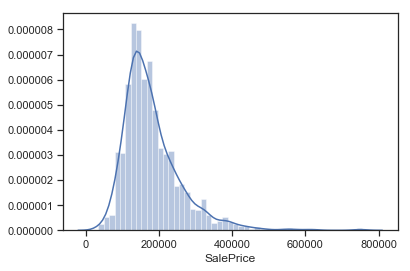

In [7]:
# Skewed target variable
sns.distplot(houseDF_train['SalePrice'])

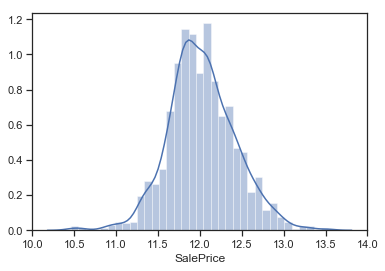

In [8]:
# 2.1- log transform the target variable
houseDF_train["SalePrice"] = np.log1p(houseDF_train["SalePrice"])
sns.distplot(houseDF_train['SalePrice'])

In [9]:
# 2.2- Transform skewed numeric variables:
numeric_vars = houseDF.dtypes[houseDF.dtypes != "object"].index
#Skewness
skewed_vars = houseDF[numeric_vars].apply(lambda x: st.skew(x.dropna())) 
skewed_vars = skewed_vars[skewed_vars > 0.75].index
houseDF[skewed_vars] = np.log1p(houseDF[skewed_vars])

In [10]:
# 3- Replacing NA values
houseDF = houseDF.fillna(houseDF.mean())

In [26]:
# Data: 
train = houseDF[:houseDF_train.shape[0]]
test = houseDF[houseDF_train.shape[0]:]
target_train = houseDF_train.SalePrice

In [27]:
# Regression Methods sklearn - Supervised Learning
# 1- Nearest Neighbors: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
#Values to test n_neighbors
param_grid = {'n_neighbors': np.arange(5, 20)}
model_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv = 5).fit(train, target_train)
#model_knn.best_params_

In [28]:
# 2- Lasso: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html
model_lasso = LassoCV(alphas = [1, 0.1, 0.01, 0.001, 0.0005], cv = 5).fit(train, target_train)

In [29]:
def rmse_cv(model, df, y):
    rmse= np.sqrt(-cross_val_score(model, df, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [30]:
rmse_knn = rmse_cv(model_knn, train, target_train)
rmse_knn

array([0.24924483, 0.27089193, 0.25471676, 0.25907352, 0.26560014])

In [31]:
rmse_lasso = rmse_cv(model_lasso, train, target_train)
rmse_lasso

array([0.10456617, 0.1320585 , 0.12450648, 0.10641638, 0.14695408])

In [32]:
print "Error medio para cada método. KNN - ",  rmse_knn.mean(), " Lasso - ", rmse_lasso.mean()

Error medio para cada método. KNN -  0.25990543593390275  Lasso -  0.12290032089344609


In [33]:
def print_submission(model, x_test, original_X, path):
    y_test_pred = model.predict(x_test)
    y_predicted = np.exp(y_test_pred) #exp to return of log
    submission = pd.DataFrame({"Id": original_X["Id"],"SalePrice": y_predicted})
    submission.loc[submission['SalePrice'] <= 0, 'SalePrice'] = 0
    submission.to_csv(path, index=False)

In [34]:
print_submission(model_lasso, test, houseDF_test, path+"submission_lasso.csv")
print_submission(model_knn, test, houseDF_test, path+"submission_knn.csv")